In [45]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import openpyxl
from scipy.signal import find_peaks

In [46]:
def spectrum(file1, file2, save_name, label1="sp1", label2="sp2"):

    path1 = os.path.join("DataSet", "G6-1", "sp1", file1)
    path2 = os.path.join("DataSet", "G6-1", "sp2", file2)
    path3 = os.path.join("Pictures", save_name)
    
    def read_files(filepath):
        wavelengths = []
        intensities = []
        with open(filepath, "r", encoding="utf-8", errors="ignore") as f:
            lines = f.readlines()

        #DataStart以降の行を抽出
        start_index = None
        for i, line in enumerate(lines):
            if "DataStart" in line:
                start_index = i + 1
                break

        #データ部分を読み取る
        for line in lines[start_index:]:
            if not line.strip():
                continue
            try:
                wl, val = map(float, line.split())
                wavelengths.append(wl)
                intensities.append(val)
            except ValueError:
                continue
        return wavelengths, intensities

    #両ファイルを読み込み
    wl1, val1 = read_files(path1)
    wl2, val2 = read_files(path2)

    #グラフ描画
    plt.figure(figsize=(7, 4))
    plt.plot(wl1, val1, label=label1, linewidth=1)
    plt.plot(wl2, val2, label=label2, linewidth=1)
    plt.xlabel("Wavelength [nm]", fontsize=14)
    plt.ylabel("Intensity [a.u.]", fontsize=14)
    plt.xlim(400, 700)
    plt.legend(loc="upper right", borderaxespad=2, fontsize=16)
    plt.tight_layout()
    plt.savefig(path3)
    plt.show()

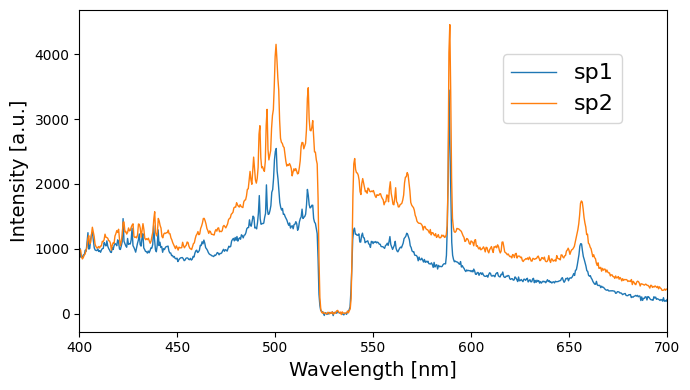

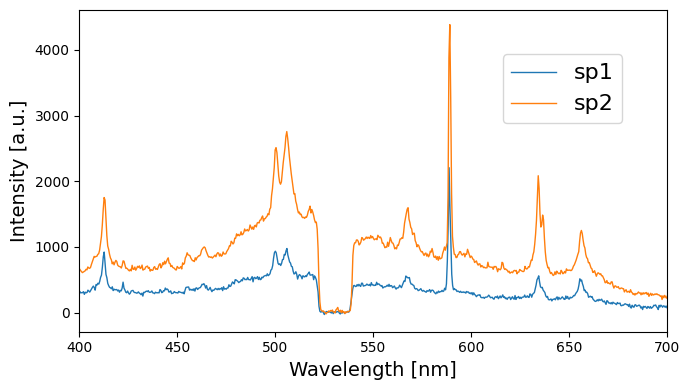

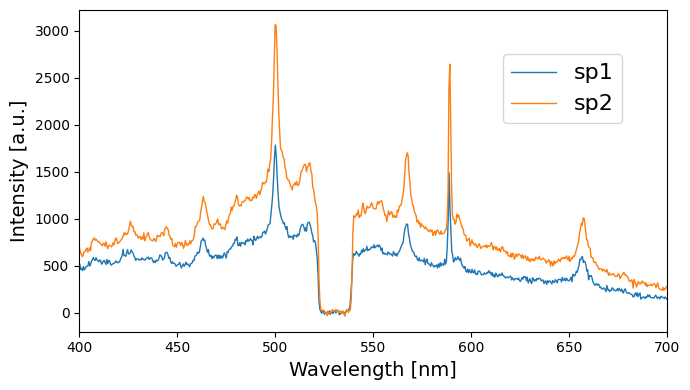

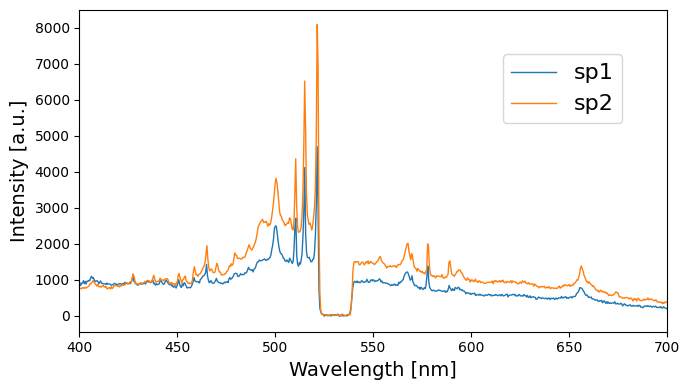

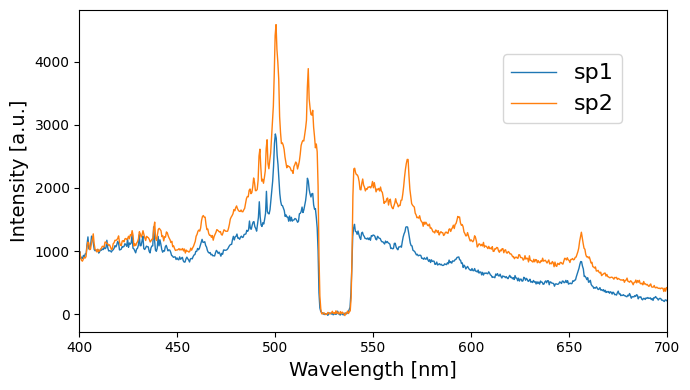

In [3]:
files_sp1 = ["sp1-22.txt", "sp1-23.txt", "sp1-24.txt", "sp1-25.txt", "sp1-26.txt"]
files_sp2 = ["sp2-22.txt", "sp2-23.txt", "sp2-24.txt", "sp2-25.txt", "sp2-26.txt"]

for i in range(0, 5):
    spectrum(files_sp1[i], files_sp2[i], f"A6-2_{i+1}.png")

In [47]:
def identify_materials(sp1_path, sp2_path, excel_path, peak_prominence=5, wavelength_tolerance=0.3):
    
    def read_files(filepath):
        wavelengths = []
        intensities = []
        with open(filepath, "r", encoding="utf-8", errors="ignore") as f:
            lines = f.readlines()

        #DataStart以降の行を抽出
        start_index = None
        for i, line in enumerate(lines):
            if "DataStart" in line:
                start_index = i + 1
                break

        #データ部分を読み取る
        for line in lines[start_index:]:
            if not line.strip():
                continue
            try:
                wl, val = map(float, line.split())
                wavelengths.append(wl)
                intensities.append(val)
            except ValueError:
                continue
        return np.array(wavelengths), np.array(intensities)
    
    #スペクトル読み込み
    wavelength1, intensities1 = read_files(sp1_path)
    wavelength2, intensities2 = read_files(sp2_path)


    #ピーク検出
    peaks1, _ = find_peaks(intensities1, prominence=peak_prominence)
    peaks2, _ = find_peaks(intensities2, prominence=peak_prominence)

    peak_wl1 = wavelength1[peaks1]
    peak_wl2 = wavelength2[peaks2]

    excel = pd.ExcelFile(excel_path)
    results = {}

    for sheet in excel.sheet_names:
        df = pd.read_excel(excel, sheet_name=sheet, usecols=[0, 1], names=["wavelength", "Aki"], header=None)
        df = df.dropna()
        
        matches1 = []
        matches2 = []

        for wl in peak_wl1:
            diff = np.abs(df["wavelength"] - wl)
            if diff.min() < wavelength_tolerance:
                matches1.append(df.loc[diff.idxmin(), "wavelength"])

        for wl in peak_wl2:
            diff = np.abs(df["wavelength"] - wl)
            if diff.min() < wavelength_tolerance:
                matches2.append(df.loc[diff.idxmin(), "wavelength"])

        total_matches = len(set(matches1 + matches2))
        results[sheet] = {
            "sp1_matches": len(matches1),
            "sp2_matches": len(matches2),
            "total": total_matches
        }

    #結果の表示
    result_df = pd.DataFrame(results).T.sort_values("total", ascending=False)
    print("=== 判定結果 ===")
    print(result_df)
    return result_df

In [48]:
result = identify_materials(
    sp1_path="DataSet/G6-1/sp1/sp1-26.txt",
    sp2_path="DataSet/G6-1/sp2/sp2-26.txt",
    excel_path="DataSet/NIST_Spectral_data.xlsx"
)

TypeError: unsupported operand type(s) for -: 'str' and 'float'